# Intermediate: Retrieve TESS Pixel Response Function Images
The Transiting Exoplanet Survey Satelite (TESS) takes time series data with 4 cameras across much of the sky.  The mission provides a product called the Pixel Response Function (PRF). The PRF is a model that describes the image of a point source and how it varies depending on where it lands on the detector. The shape of the image comes from the optical point spread function, jitter during observations, as well as the intra-pixel location of where the light lands.  These PRFs can be used to fit the data to obtain precise locations or brightness of stars. This notebook shows you how to open the FITS-formatted PRF images and calculate a PRF model for a specific location on a detector. 

More information about the PRF can be found in the [TESS Archive Manual.](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual) The PRF models were created by the mission by fitting to micro-dithered data taken during PRF commissioning exercises. See the Instrument Handbook for details on the data collection. 

The pixel response functions in FITS or Matlab format and are available from the [models/prf_fitsfiles](https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/) directory at MAST. There are 25 sub-pixel sampled PRF image for an evenly spaced grid across each of the 16 CCDs and cameras. Each CCD/camera combination is in its own subdirectory at MAST. The column and row information is specified in the file name.  A 13x13 PRF image is provided for 9x9 subpixel locations, allowing you a tenth of pixel precision without having to interpolate.  The 9x9 grid of 13x13 images are interwoven into one 117x117 image, making retrieving the exact sub-pixel location a bit tricky.

There is no package to retrieve or work with the PRFs. So this tutorial starts by defining some functions to make it easier to parse the files and retrieve the PRF we are looking for. Each function is documented, but a quick overview is given below.   

If you just want to understand the shapes of the PRFs, skip ahead to the section [Obtain PRF at an image location](#obtain_PRF).


### Description of the PRF retrieval code
The primary function (`getPrfAtColRowFits`) takes a column, row, ccd, camera and sector and returns a 13x13 image of the best PRF interpolated from the grid of PRFs provided in the files.  It uses the ccd, camera and sector information to determine the name of the relevant PRF file in `pathLookup`. Then `determineClosestTessColRow` uses the requested row and column, finds the 4 nearest positions on the detector for which the mission provided a PRF file. Open those files and pull out the appropriate sub-pixel image. Once the four 13x13 sub-pixel PRF images are extracted, `interpolatePrf` interpolates them to the specfied pixel location. The main function then returns this interpolated PRF image.

### Required Software
- astropy.io
- numpy
- matplotlib
- astroquery.mast

----

## Code to retrieve a TESS PRF image

In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt

### Determine the name of the PRF based on ccd camera and sector

In [2]:
def pathLookup(ccd, camera, sector):
    """
    Gets the datestring and the subdirectory for the specified PRF. 
    The datestring and directory name can be found from the ccd, camera and sector.
    
    Inputs
    -------
    ccd
        (int) number of the TESS ccd. Accepts values from 1-4.
    camera
        (int) number of the TESS camera. Accepts values from 1-4
    sector
        (int) number of the TESS sector. Accepts values of 1 and above.
    
    Returns
    -------
    datestring
        (str) Date string used in the TESS prf files name.
    add_path
        (str) Directory name where the TESS PRF is stored. (e.g. "/start_s0001/")
    """ 
    if sector < 1:
        raise ValueError("Sector must be greater than 0.")
    if (camera > 4) | (ccd > 4):
        raise ValueError("Camera or CCD is larger than 4.")

    if sector <= 3:
        add_path = "/start_s0001/"
        datestring = "2018243163600"

        if camera >= 3:
            datestring = "2018243163601"
        elif (camera == 2) & (ccd == 4):
            datestring = "2018243163601"
        
    else:
        add_path = "/start_s0004/"
        datestring = "2019107181900"
        if (camera == 1) & (ccd >= 2):
            datestring = "2019107181901"
        elif (camera == 2):
            datestring = "2019107181901"
        elif (camera == 3) & (ccd >= 2) :
            datestring = "2019107181902"
        elif (camera == 4):
            datestring = "2019107181902"

    return datestring, add_path

### Read in one PRF FITS File

In [3]:
def readOnePrfFitsFile(ccd, camera, col, row, path, datestring):
    """
    reads in the full, interleaved prf Array for a single row,col,ccd,camera location.
    
    Inputs
    -------
    ccd
        (int) CCD number
    camera
        (int) Camera number
    col
        (float) Specific column where the PRF was sampled.
    row
        (float) Specific row where the PRF was sampled.
    path
        (string) The full path of the data file. Can be the MAST Web address
        
    Returns
    ------
    prfArray
        (np array) Full 117 x 117 interleaved prf Array for the requested file.      
    """
        
    fn = "cam%u_ccd%u/tess%13s-prf-%1u-%1u-row%04u-col%04u.fits" % \
        (camera, ccd, datestring, camera, ccd, row, col)

    filepath = os.path.join(path, fn)
    hdulistObj = fits.open(filepath)
    prfArray = hdulistObj[0].data

    return prfArray

def determineFourClosestPrfLoc(col, row):
    """
    Determine the four pairs of col,row positions of your target. 
    These are specific to TESS and where they chose to report their PRFs.
    Inputs
    ------
    col
        (float) Column position
    row
        (float) Row position.
    
    Returns
    -------
    imagePos
        (list) A list of (col,row) pairs.
    """

    posRows = np.array([1, 513, 1025, 1536, 2048])
    posCols = np.array([45, 557, 1069, 1580,2092])

    difcol = np.abs(posCols - col)
    difrow = np.abs(posRows - row)

    # Expand out to the four image position to interpolate between,
    # Return as a list of tuples.
    imagePos = []
    for r in posRows[np.argsort(difrow)[0:2]]:
        for c in posCols[np.argsort(difcol)[0:2]]:
            imagePos.append((c,r))

    return imagePos

In [4]:
def getOffsetsFromPixelFractions(col, row):
    """
    Determine just the fractional part (the intra-pixel part) of the col,row position.  
    For example, if (col, row) = (123.4, 987.6), then
    (colFrac, rowFrac) = (.4, .6). 
    
    Function then returns the offset necessary for addressing the interleaved PRF array.
    to ensure you get the location appropriate for your sub-pixel values.
    
    Inputs
    ------
    col
        (float) Column position
    row
        (float) Row position.
    
    Returns
    ------
    (colFrac, rowFrac)
       (int, int) offset necessary for addressing the interleaved PRF array.
    """
    gridSize = 9

    colFrac = np.remainder(float(col), 1)
    rowFrac = np.remainder(float(row), 1)

    colOffset = gridSize - np.round(gridSize * colFrac) - 1
    rowOffset = gridSize - np.round(gridSize * rowFrac) - 1

    return int(colOffset), int(rowOffset)

def getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset):
    """
    The 13x13 pixel PRFs on at each grid location are sampled at a 9x9 intra-pixel grid, to
    describe how the PRF changes as the star moves by a fraction of a pixel in row or column.
    To extract out a single PRF, you need to address the 117x117 array in a funny way
    (117 = 13x9). Essentially you need to pull out every 9th element in the array, i.e.

    .. code-block:: python

        img = array[ [colOffset, colOffset+9, colOffset+18, ...],
                     [rowOffset, rowOffset+9, ...] ]
    
    Inputs
    ------
    prfArray
        117x117 interleaved PRF array
    colOffset, rowOffset
        The offset used to address the column and row in the interleaved PRF
    
    Returns
    ------
    prf
        13x13 PRF image for the specified column and row offset
    
    """
    gridSize = 9

    assert colOffset < gridSize
    assert rowOffset < gridSize

    # Number of pixels in regularly sampled PRF. Should be 13x13
    nColOut, nRowOut = prfArray.shape
    nColOut /= float(gridSize)
    nRowOut /= float(gridSize)

    iCol = colOffset + (np.arange(nColOut) * gridSize).astype(int)
    iRow = rowOffset + (np.arange(nRowOut) * gridSize).astype(int)

    tmp = prfArray[iRow, :]
    prf = tmp[:,iCol]

    return prf


In [5]:
def interpolatePrf(regPrfArray, col, row, imagePos):
    """
    Interpolate between 4 images to find the best PRF at the specified column and row.
    This is a simple linear interpolation.
    
    Inputs
    -------
    regPrfArray 
        13x13x4 prf image array of the four nearby locations.
        
    col and row 
        (float) the location to interpolate to.
        
    imagePos
        (list) 4 floating point (col, row) locations
        
    Returns
    ----
    Single interpolated PRF image.
    """
    p11, p21, p12, p22 = regPrfArray
    c0 = imagePos[0][0]
    c1 = imagePos[1][0]
    r0 = imagePos[0][1]
    r1 = imagePos[2][1]

    assert c0 != c1
    assert r0 != r1

    dCol = (col-c0) / (c1-c0)
    dRow = (row-r0) / (r1 - r0)

    # Intpolate across the rows
    tmp1 = p11 + (p21 - p11) * dCol
    tmp2 = p12 + (p22 - p12) * dCol

    # Interpolate across the columns
    out = tmp1 + (tmp2-tmp1) * dRow
    return out

## The main functions
We define two main functions.  The first, `getNearestPrfFits`, returns only the PRF in the grid of 25x25 PRF locations provided by the mission that is nearest to the (column, row) location specified.  The second, `getPrfAtColRowFits`, does a linear interpolation between the four PRFs nearest to the location specified and returns that PRF.

In [6]:
def getNearestPrfFits(col, row, ccd, camera, sector, path):
    """
    Main Function
    Return a 13x13 PRF image for a single location. No interpolation
    
    This function is identical to getPrfAtColRowFits except it does not perform the interpolation step.
    
    Inputs
    ---------
    col, row
        (floats) Location on CCD to lookup. The origin of the CCD is the bottom left.
        Increasing column increases the "x-direction", and row increases the "y-direction"
        The column coordinate system starts at column 45.
    ccd
        (int) CCD number. There are 4 CCDs per camera
    camera
        (int) Camera number. The instrument has 4 cameras
    sector
        (int)  Sector number, greater than or equal to 1.

    Returns
    ---------
    A 13x13 numpy image array of the nearest PRF to the specifed column and row.
    """
    col = float(col)
    row = float(row)
    prfImages = []
    
    # Determine a datestring in the file name and the path based on ccd/camer/sector
    datestring, addPath = pathLookup(ccd, camera, sector)
    path = path + addPath
    
    # Convert the fractional pixels to the offset required for the interleaved pixels.
    colOffset, rowOffset = getOffsetsFromPixelFractions(col, row)
    
    # Determine the 4 (col,row) locations with exact PRF measurements.
    imagePos = determineFourClosestPrfLoc(col, row)
    bestPos = imagePos[0]
    prfArray = readOnePrfFitsFile(ccd, camera, bestPos[0], bestPos[1], path, datestring)
            
    prfImage = getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset)       

    return prfImage

In [7]:
def getPrfAtColRowFits(col, row, ccd, camera, sector, path):
    """
    Main Function
    Lookup a 13x13 PRF image for a single location
    
    Inputs
    ---------
    col, row
        (floats) Location on CCD to lookup. The origin of the CCD is the bottom left.
        Increasing column increases the "x-direction", and row increases the "y-direction"
        The column coordinate system starts at column 45.
    ccd
        (int) CCD number. There are 4 CCDs per camera
    camera
        (int) Camera number. The instrument has 4 cameras
    sector
        (int)  Sector number, greater than or equal to 1.
    path
        (str) Directory or URL where the PRF fits files are located

    Returns
    ---------
    A 13x13 numpy image array of the interpolated PRF.
    """
    col = float(col)
    row = float(row)
    prfImages = []
    
    # Determine a datestring in the file name and the path based on ccd/camera/sector
    datestring, subDirectory = pathLookup(ccd, camera, sector)
    path = path + subDirectory
    
    # Convert the fractional pixels to the offset required for the interleaved pixels.
    colOffset, rowOffset = getOffsetsFromPixelFractions(col, row)
    
    # Determine the 4 (col,row) locations with exact PRF measurements.
    imagePos = determineFourClosestPrfLoc(col, row)

    # Loop over the 4 locations and read in each file and extract the sub-pixel location.
    for pos in imagePos:
            prfArray = readOnePrfFitsFile(ccd, camera, pos[0], pos[1], path, datestring)
            
            img = getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset)       
            prfImages.append(img)

    # Simple linear interpolate across the 4 locations.
    interpolatedPrf = interpolatePrf(prfImages, col, row, imagePos)

    return interpolatedPrf

----

<a id="obtain_PRF"></a>
## Obtain a PRF at a particular image location
Notice that both of our main functions can accept either a path to the location on your local machine where the PRF fits files are stored, or a URL pointing to the same directory at MAST.  We recommend downloading the PRF fits files if you expect to use them frequently. Here we use the URL for the PRFs.

In [8]:
# Define the location for which we want to retrieve the PRF.
col = 125.2
row = 544.1
ccd = 2
camera = 2
sector = 1

# This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

prf = getPrfAtColRowFits(col, row, ccd, camera, sector, path)
closestPrf = getNearestPrfFits(col, row, ccd, camera, sector, path)

Below is the code to plot both the closest PRF and a PRF derived from a linear interpolation between the 4 nearest PRFs provided in the file.  They are plotted with a log scale in order to let you really see the full extent of the PRFs.  Also, we show the difference between the two.

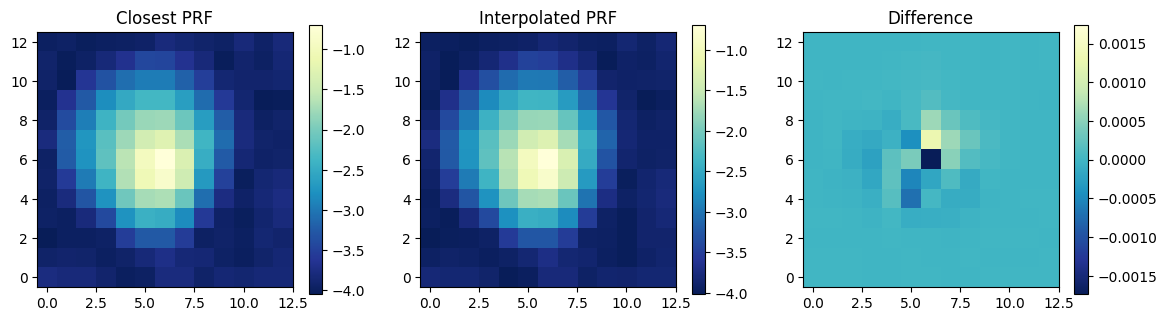

In [9]:
# Commands to make the plots looks a bit nicer.
kwargs = {'origin':'lower', 'interpolation':'nearest', 'cmap':plt.cm.YlGnBu_r}

plt.figure(figsize=(14,3.5))
plt.subplot(131)
plt.imshow(np.log10(closestPrf), **kwargs)
plt.colorbar()
plt.title('Closest PRF')
plt.subplot(132)
plt.imshow(np.log10(prf), **kwargs)
plt.colorbar()
plt.title('Interpolated PRF')
plt.subplot(133)

diff = closestPrf - prf
plt.imshow(diff, **kwargs)
mx = max( np.max(diff), np.fabs(np.min(diff)) )
plt.clim(-mx, mx)
plt.title('Difference')
plt.colorbar()

## Sample of PRFs across the chip
Let's plot the PRF across a single CCD to show how it varies. The PRF images are plotted using a log scale to see the difference in the wings of the PRF. 

Notice that the nice round PRF shape is in the corner of our grid, near (1850,1850).  This is because there are 4 CCDs for each camera and so this location is nearest to the center of the focal plane and has the least optical distortion.  Note that the read-out direction of the CCDs is different for each CCD. See Figure 2.6 of the [Instrument Manual](http://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_documents/TESS_Instrument_Handbook_v0.1.pdf#page=16) to determine the actual orientation of each CCD. 

As an experiment you should change the ccd value see how it varies from one CCD to another across the TESS field-of-view. 


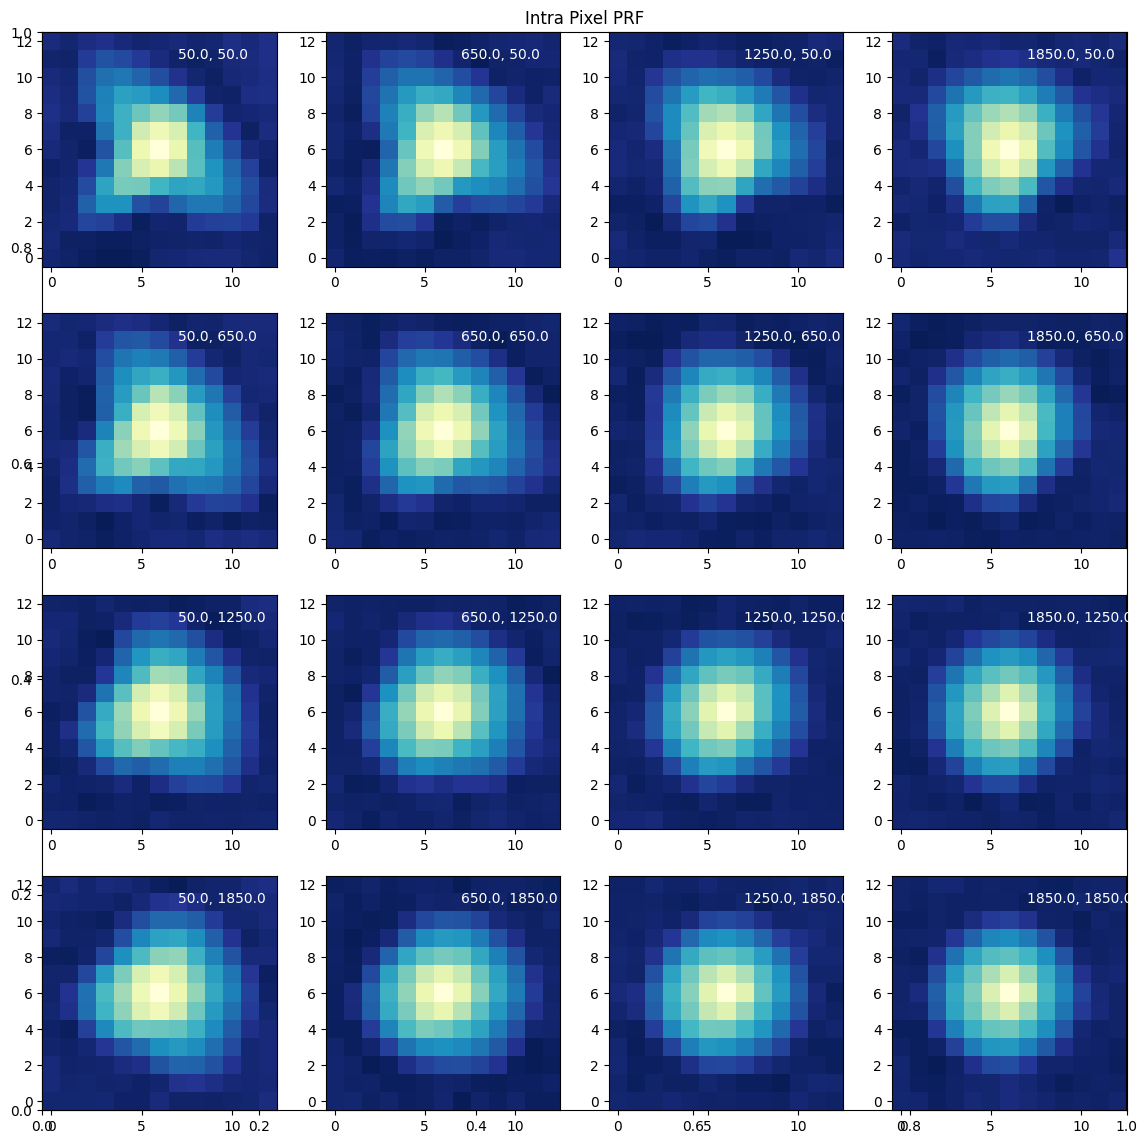

In [10]:
# Define the CCD for which we want to retrieve the PRFs
sector = 1   #Values 1 - 13
camera = 3   #values 1 - 4
ccd = 1      #Values 1 - 4

# Create plot
plt.figure(figsize=(14, 14))
plt.title("Intra Pixel PRF")

# Loop over the 25 different locations
nplot=0
for row in np.arange(50, 1851, 600):
    for col in np.arange(50, 1851, 600):
        nplot=nplot + 1
        plt.subplot(4, 4, nplot)
        prf = getPrfAtColRowFits(col + .5, row + .5, ccd, camera, sector, path)
        plt.imshow(np.log10(prf), **kwargs)
        plt.annotate("%.1f, %.1f" % (col, row), (7, 11), color='w')

## Sample the PRF at sub-pixel locations. 
The PRF varies quite a bit depending on where on the pixel the star's light falls.  As a result it is instructive to plot the PRF for one pixel at various intrapixel locations.  In the following we show a 5x5 grid of the prf above. Note that there are actually 9 different intra-pixel locations provided in the TESS Mission PRFs.  Here we plot them on a linear scale because most of the variation is in the brightest pixels of the PRF.

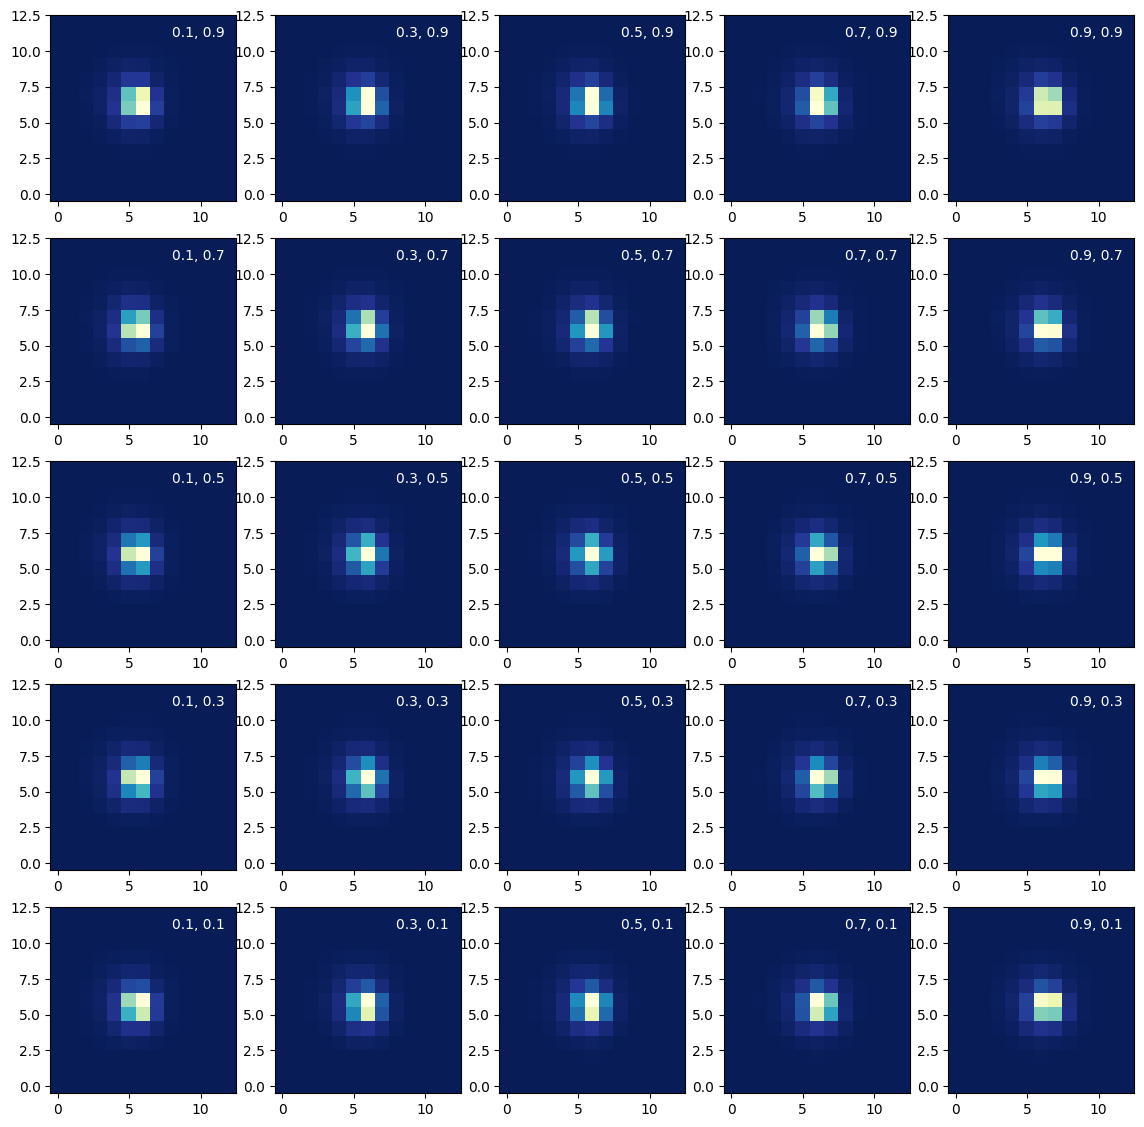

In [11]:
# Define the location for which we want to retrieve the PRF.
col = 125.0
row = 1044.0
ccd = 2
camera = 2
sector = 1

# This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

kwargs['vmax'] = .2  
plt.figure(figsize = (14, 14))

# Loop over the 5 different locations
nplot=0
for row_add in np.arange(0.9, 0, -.2):
    for col_add in np.arange(0.1, 1, .2):
        nplot=nplot+1
        plt.subplot(5,5,nplot)
        prf = getPrfAtColRowFits(col + col_add, row + row_add, ccd, camera, sector, path)
        plt.imshow(prf, **kwargs)
        plt.annotate("%.1f, %.1f" % (col_add, row_add), (8, 11), color='w')
        
_ = kwargs.pop('vmax')  #unset vmax


## Compare the PRF to an Image
In the following we pull down the image of a star observed by TESS. We do this using TessCut and Catalogs, both are packages available through astroquery.mast. MAST maintains a separate tutorial on how to use these tools. Tesscut cuts out a timeseries of a subsection of the TESS FFIs.  We plot that image and attmept to estimate a PRF for that star. This examples is done for TIC 307214209. It is chosen because it is relatively isolated in the field, making it easier to match the PRFs.


In [12]:
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs

ticid = 307214209
target = "TIC %u" % ticid
size = 13

catalogData = Catalogs.query_criteria(catalog = "Tic", ID = ticid)
ra = catalogData['ra']
dec = catalogData['dec']

coord="%f, %f" % (ra,dec)

### Use Tesscut to retrieve a 13x13 square image from a calibrated FFI
TESScut requires a string containing the RA and Dec of the location and a size for how big the cutout should be. I then take the median of all the images in the stack for comparison to the PRF.  The Header contains information about the location of the pixels on the original calibrated FFI. 1CRV4P and 2CRV4P provide the column and row of the center of the cutout in the original physical coordinate system of the FFI.

In [13]:
hdulist = Tesscut.get_cutouts(coordinates=coord, size=size)
n = 1 # There is more than one sector, we chose the second one

### Determine the column and row of the central pixel

In [14]:
# Pull out the location of the middle of the CCD from the Physics WCS in the header.
image_head = hdulist[n][1].header
prime_head = hdulist[n][0].header
ap_head = hdulist[n][2].header
col_center = image_head['1CRV4P']
row_center = image_head['2CRV4P']
print("Header col,row: %f, %f" % (col_center, row_center))

Header col,row: 1041.000000, 75.000000


### Determine the location of the star
Usually, if the TIC is accurate, the location of the star will be right in the center. In case it is not, we look for the brightest pixel in the median of our time series of images and request our PRF for that location. In this case, we end up with the central pixel.

In [15]:
# Get the image of the median of the time series.
image_array = hdulist[n][1].data['FLUX']
image_stack = np.median(image_array,axis=0)

sortedindex=np.dstack(np.unravel_index(np.argsort(image_stack.ravel()), (13, 13)))
brightest = sortedindex[-1][-1]
bright_col = brightest[0] - 6 + col_center
bright_row = brightest[1] - 6 + row_center

print("Bright star col,row: %f, %f" % (bright_col, bright_row))

Bright star col,row: 1041.000000, 75.000000


### Look up Sector, Camera, and CCD
Use the TessCut header to determine the sector, camera, and ccd of the image.

In [16]:
camera = prime_head['CAMERA']
ccd = prime_head['CCD']
sector = prime_head['SECTOR']
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"
prf_col_offset = 44

### Plot the sub-pixel PRFs
Below we compare the image from the FFI to the various sub-pixel locations to choose the one that looks most like the image. For most use cases, you would most likely want to perform a fit, but for our purposes of understanding the PRFs, this will be sufficient.

Notice we define an arbitrary offset above, prf_col_offset. We need to add a 44 pixel offset to the column in the PRF request.  This is because the PRF request uses a different physical coordinate system than our calibrated FFIs. They use 45 as their first column but the calibrated FFIs use 1 as the first column. 

First we plot an image of the median of all the images in the pixel time series returned by TESScut.

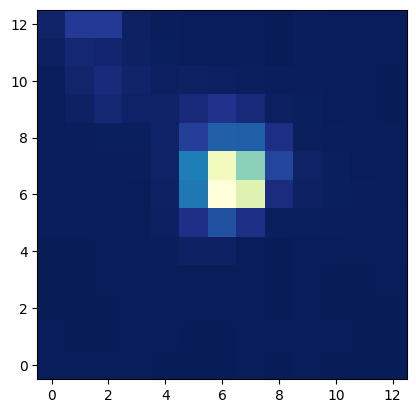

In [17]:
plt.imshow(image_stack, **kwargs)

Here is a 5x5 grid showing the PRF as it would look if it fell on different parts of the pixel. A quick chi-by-eye tells me that (0.7,0.9) is a pretty good match.

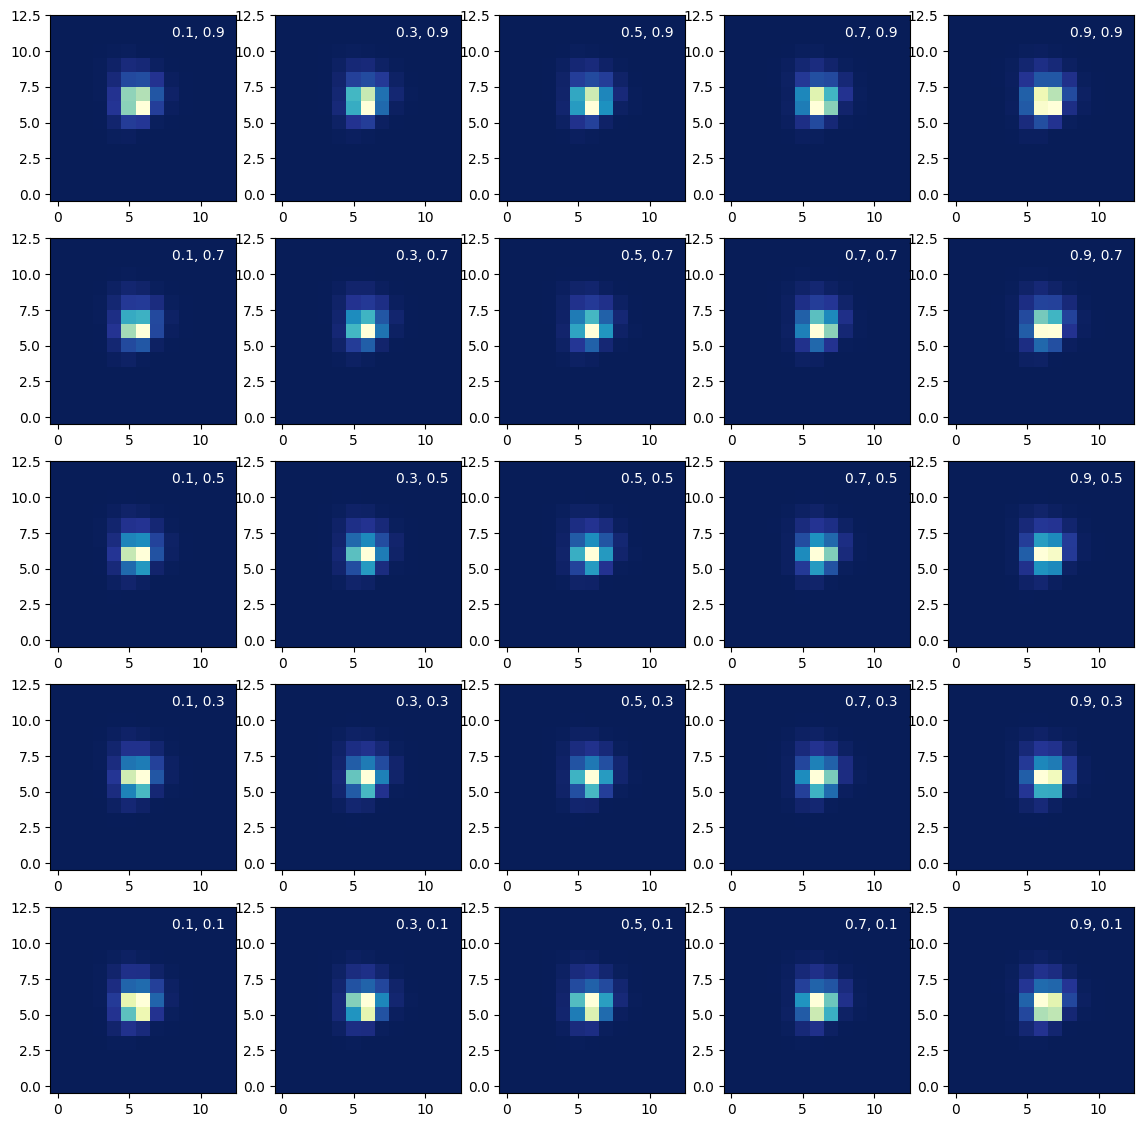

In [18]:
# Loop over the 5 different locations
plt.figure(figsize = (14, 14))
nplot = 0
for row_add in np.arange(0.9, 0, -.2):
    for col_add in np.arange(0.1,1,.2):
        nplot=nplot+1
        plt.subplot(5,5,nplot)
        col = bright_col + col_add + prf_col_offset
        row = bright_row + row_add
        prf = getPrfAtColRowFits(col, row, ccd, camera, sector, path)
        plt.imshow(prf, **kwargs)
        plt.annotate("%.1f, %.1f" % (col_add, row_add), (8,11), color='w')

Here we obtain the interpolated PRF for our image given the column and row we determinted, including the subpixel information. 

In [19]:
# offsets from the corner of the pixel.
offcol = .7
offrow = .9

# Retrieve the PRF using our functions above.
prf = getPrfAtColRowFits(bright_col + offcol + prf_col_offset, bright_row + offrow, ccd, camera, sector, path)

### Compare PRF and FFI cutout
Here we look at the difference between our actual image and the PRF we requested. To do this well we need to subtact the background from the image and then we need to scale up the PRF to match the flux of our star. We finish by plotting the background subtracted image, the flux-scaled PRF, and the significance of the difference (assuming Poisson statistics in the image). 

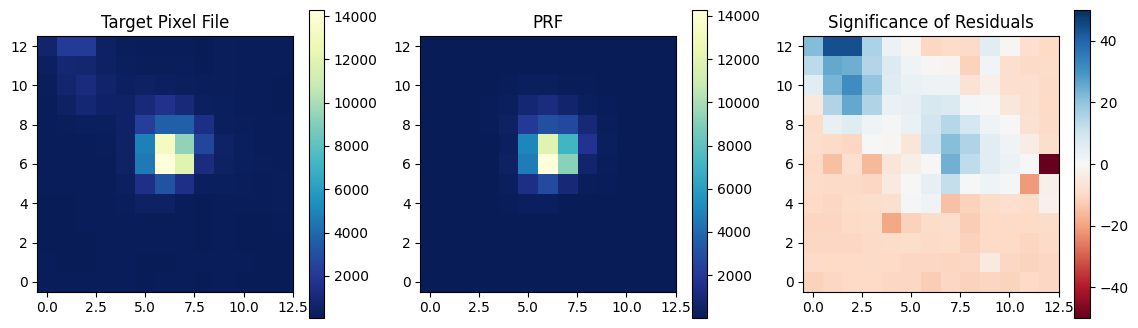

In [20]:
# estimate background using median
image_subbkg =  image_stack - np.median(image_stack)
# Scaling based on brightest pixels.
scale = np.max(image_subbkg)/np.max(prf)
# Take the difference
diff =  image_subbkg - prf * scale 

# Estimate the signficance of the residuals
sigma = diff / (np.sqrt(np.abs(image_subbkg)) + .05)

# Plot
vm = np.max(image_subbkg)
plt.figure(figsize = (14, 4))
plt.subplot(131)
plt.imshow(image_stack, **kwargs, vmax=vm)
plt.title('Target Pixel File')
plt.colorbar()

plt.subplot(132)
plt.imshow(prf * scale, **kwargs, vmax = vm)
plt.title('PRF')
plt.colorbar()

plt.subplot(133)
plt.imshow(sigma, origin = "lower", interpolation = 'nearest', cmap = 'RdBu', vmin = -50, vmax = 50)
plt.title('Significance of Residuals')
plt.colorbar()

### Residuals
This is not an optimal fit. By playing around with `offcol` and `offrow` above, you will be able to find a slightly better fit than the one shown above.  (Hint, try (0.8, 0.9) for the column and row offsets.)

We also did not account for all the stars in our image. We picked a rather isolated, 8th magnitude star, but there is still another 10th magnitude star about 7 pixels away, and a 15th magnitude star about 5 pixels away from our star (both are towards the upper left in our image). A good PRF fit will include all of this information. Both of these can be seen clearly in the residuals. We also see some residual signal from our primary star that hopefully a better fit that properly scales the PRF to the flux of the star will remove more cleanly.

### Summary
This notebook provided you with code to open the PRFs and retrieve one that matches the physical location of a star on a real TESS image.  You learned that the PRF depends not only on the location of the star on the chip, but also varies significantly by the sub-pixel location.  The wings of the PRFs depend strongly on the location of the star on the chip with the most circular shapes near the center of the image. The shape of the bright central peak of the PRF depends strongly on the sub-pixel location.  

<a id="about_ID"></a>
## About this Notebook
**Authors:** 
<br>Susan E. Mullally, STScI 
<br>Fergal Mullally
<br>**Updated On:** 2019-06-13

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 

### Assert Statements
Test to check that the code is returning the correct PRFs. Do not edit the following lines.

In [21]:
# Assert statements to ensure that the PRFs are being calculated correctly
prf = getPrfAtColRowFits(120.1, 500.0, 1, 2, 1, "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/")
assert np.abs(prf[0,0] - 0.00023311895) < 2e-10

prf = getPrfAtColRowFits(1000.1, 1500.0, 1, 2, 1, "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/")
assert np.abs(prf[0,0] - 0.0001082187719) < 2e-10
assert np.abs(prf[12,12] - 0.00013416155932937155) < 2e-10

prf = getPrfAtColRowFits(1000.1, 1500.0, 3, 1, 8, "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/")
assert np.abs(prf[0,0] - 0.00019209127583606498) < 2e-10